In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

sys.path.append("../")
import covid19_ode_inference as cov19_ode

In [4]:
id_func = lambda x: x
remove_beg_end = lambda x: x[1:-1]
data1 = np.loadtxt("example2.csv", skiprows=1, delimiter=",", converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
data2 = np.loadtxt("example2_SIR.csv", skiprows=1, delimiter=",", converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end, 3:remove_beg_end, 4:remove_beg_end, 5:remove_beg_end})
N=100_000
until=120
cases_data = data1[:until, 2]
t_cases_data = np.arange(len(cases_data))
seropos_data = (1 - data2[:until, 1]/N)
dead_data = np.cumsum(data2[:until+1,3]*0.0005)[1:]
t_seropos_data = np.array([1,75,180])
t_seropos_data = np.array(list(range(1,until,20)))
seropos_data_subs = seropos_data[t_seropos_data]
len_sim = len(cases_data)
time=t_cases_data

In [ ]:
model = cov19_ode.examples.model_cases_seropositivity_dead(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    dead_data=dead_data,
    sim_model=False,
    fact_subs=8,
#     cp_reporting_kwargs=dict(num_cps=7),
    cp_reporting_kwargs=dict(num_cps=3,cp_interval=27.),
    cp_R_kwargs=dict(num_cps=3,cp_interval=27.),
    cp_fatality_kwargs=dict(num_cps=3,cp_interval=30.),
)

In [18]:

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode="JAX")
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode="JAX")
dlogp_fn(ip)
print("Timing JAX compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode='FAST_RUN')
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode='FAST_RUN')
dlogp_fn(ip)
print("Timing C compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)
;

Timing JAX compiled:
243 µs ± 680 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
297 µs ± 665 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Timing C compiled:
392 µs ± 2.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
806 µs ± 6.25 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


''

In [8]:
def get_initial_random_points(num_chains, model):
    num_tries = 1000
    init = pm.sample_prior_predictive(num_tries , model=model, return_inferencedata=True)
    points_with_nan = np.unique(np.argwhere(np.isnan(np.array(init.prior_predictive["new_reported_data"])))[:,1])
    print(f"Percentage of initial_points with nans: {len(points_with_nan)/num_tries:.0%}")
    init_dict = []
    for chain in range(num_tries):
        if chain not in points_with_nan:
            init_dict.append({key: np.array(val)[0, chain] for (key, val) in init.prior.items() })
        if len(init_dict) == num_chains:
            break
    else: 
        raise RuntimeError("Not enough initial points without nans")
    return init_dict

In [9]:
num_chains = 6

init_dict = get_initial_random_points(num_chains, model = cov19_ode.examples.model_cases_seropositivity_dead(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    dead_data=dead_data,
    sim_model=False,
    fact_subs=8,
#     cp_reporting_kwargs=dict(num_cps=7),
    cp_reporting_kwargs=dict(num_cps=3,cp_interval=27.),
    cp_R_kwargs=dict(num_cps=3,cp_interval=27.),
    cp_fatality_kwargs=dict(num_cps=3,cp_interval=30.),
    truncater=pm.Truncated
))

idata_gen = cov19_ode.custom_sample.my_sample(
# idata_gen = pm.sample(
    model=model,
    tune=500,
    draws=200,
    cores=num_chains,
    discard_tuned_samples=False,
    nuts_sampler="mynumpyro",
    target_accept=0.9,
#     initvals=init_dict,
    nuts_sampler_kwargs=dict(
        chain_method="parallel", 
        nuts_kwargs=dict(max_tree_depth=10,
                         find_heuristic_step_size=True,
                         regularize_mass_matrix=False,
#                          step_size=1,
                        )
    ),
    idata_kwargs=dict(
        save_warmup=True,
    ),
    keep_warning_stat=True,
)
warnings = pm.stats.convergence.run_convergence_checks(idata_gen,model=model,)
pm.stats.convergence.log_warnings(warnings) 

Sampling: [D_0, Delta_rhos_R_raw, Delta_rhos_fatality_raw, Delta_rhos_raw, Delta_t_pos_R, Delta_t_pos_fatality, Delta_t_pos_rep, R0, dead_data, delta_base, error_dead, error_report, error_sero, eta_base, frac_I_0, frac_S_0, inv_epsilon, inv_gamma, new_reported_data, sero_data, sigma_Delta_rhos, sigma_Delta_rhos_R, sigma_Delta_rhos_fatality, transients_R_raw, transients_fatality_raw, transients_rep_raw]
Only 200 samples in chain.


Percentage of initial_points with nans: 59%


/home/test/covid19_ode_inference2/notebooks/../covid19_ode_inference/custom_sample.py:281: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:31.840311
Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Sampling time =  0:03:10.565525
Transforming variables...


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


Transformation time =  0:00:13.338684
{'save_warmup': True}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


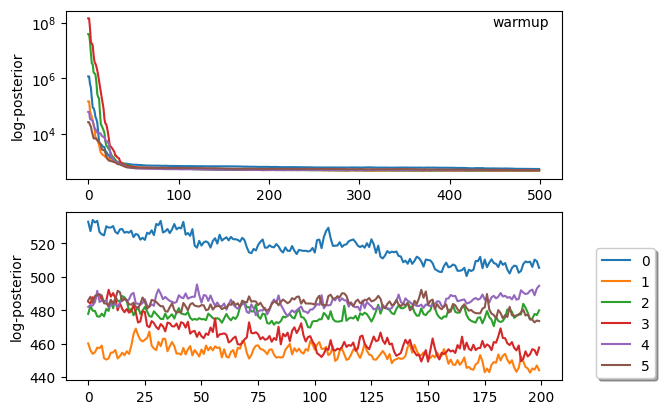

In [10]:
chainsel=[0,1,2,3,4,5]
fig, ax = plt.subplots(2)
def my_get_subplot(i):
    return ax[i]
ax_warmup = my_get_subplot(0).plot(idata_gen.warmup_sample_stats["lp"].T)
my_get_subplot(0).set_ylabel("log-posterior");
my_get_subplot(0).set_yscale("log")
fig.legend(title="warmup", loc='right', bbox_to_anchor=(0.9,0.85),shadow=False,frameon=False);
for i in range(len(ax_warmup)):
    ax_warmup[i].set_color("C"+str(i))

idata = idata_gen.sel(chain=chainsel, groups="posterior_groups")

ax_sample = my_get_subplot(1).plot(idata.sample_stats["lp"].T)
my_get_subplot(1).set_ylabel("log-posterior");
for i in range(len(ax_sample)):
    ax_sample[i].set_color("C"+str(chainsel[i]))

fig.legend(np.arange(0,len(ax_warmup)), loc='lower center', bbox_to_anchor=(1, 0.1),
          fancybox=True, shadow=True, ncol=1);

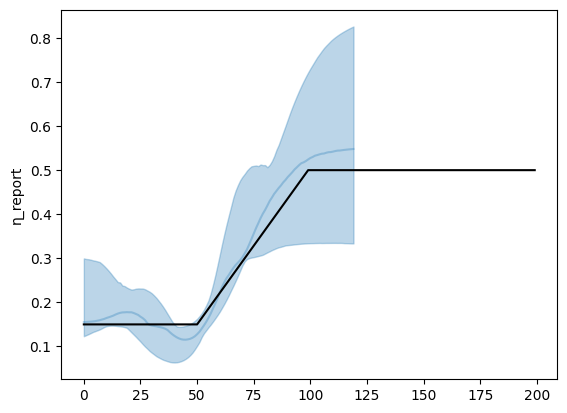

In [11]:
values_inferred = idata.posterior["eta_report"].to_numpy().reshape((-1, len_sim))

plt.plot(time, np.median(values_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(values_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 2]/data1[:, 1], color="black")
plt.ylabel("η_report");

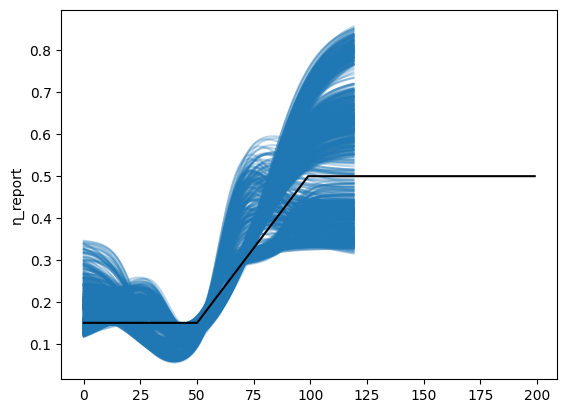

In [12]:

plt.plot(time, values_inferred.T, color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 2]/data1[:, 1], color="black")
plt.ylabel("η_report");


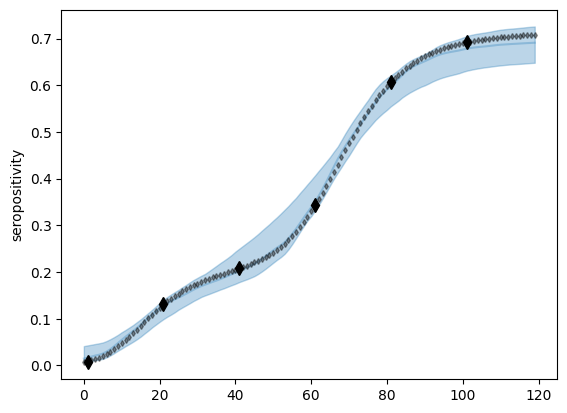

In [13]:
seropositive_inferred = idata.posterior["Sero_t"].to_numpy().reshape((-1, len_sim))

plt.fill_between(time, *np.percentile(seropositive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(time, np.median(seropositive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.plot(seropos_data, marker="d", color="black", ls="", ms=3, alpha=0.4);
plt.plot(t_seropos_data, seropos_data[t_seropos_data], marker="d", color="black", ls="", ms=7);
plt.ylabel("seropositivity");


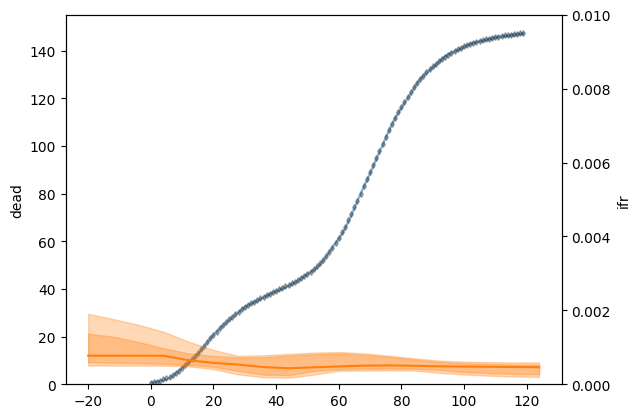

In [14]:
dead_inferred = idata.posterior["Dead_t"].to_numpy().reshape((-1, len_sim))

plt.plot(t_cases_data, dead_data, marker="d", color="black", ls="", ms=3, alpha=0.3);
plt.fill_between(time, *np.percentile(dead_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(time, np.median(dead_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.ylabel("dead");

t_ode = np.arange(-20,len_sim+8,8)
ifr_inferred = idata.posterior["ifr_t"].to_numpy().reshape((-1, int(np.ceil((len_sim+20+8)/8))))

ax = plt.gca()
ax2 = ax.twinx()
ax2.fill_between(t_ode, *np.percentile(ifr_inferred, q=(2.5,97.5), axis=0), color="C1", alpha = 0.3,zorder=-2)
ax2.fill_between(t_ode, *np.percentile(ifr_inferred, q=(15,85), axis=0), color="C1", alpha = 0.3,zorder=-2)
ax2.plot(t_ode, np.median(ifr_inferred, axis=0), color="C1")
ax2.set_ylabel("ifr")
ax.set_ylim((0))
ax2.set_ylim((0,0.01));


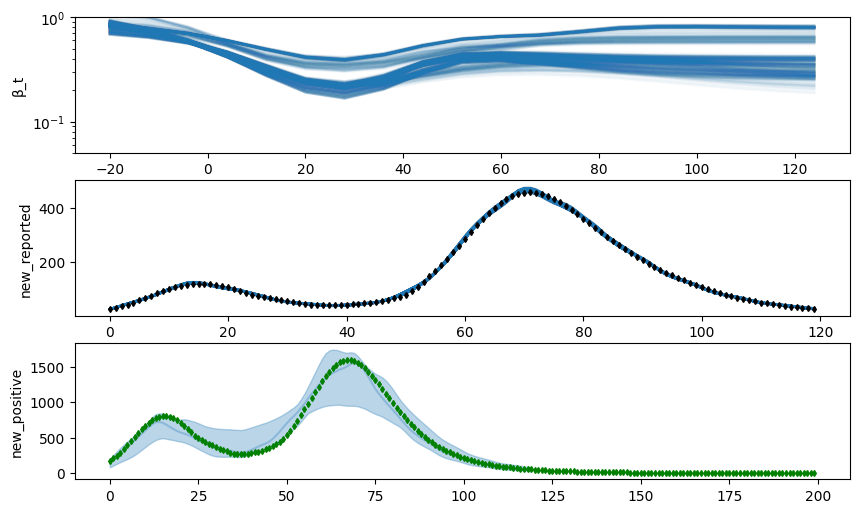

In [15]:
f, axes = plt.subplots(3,1, figsize = (10,6))
t_solve_ODE = model.coords["t_solve_ODE"]

f.sca(axes[0])
plt.plot(t_solve_ODE, idata.posterior["beta_t"].to_numpy().reshape((-1, len(t_solve_ODE))).T, color="tab:blue", alpha = 0.02);
plt.ylabel("β_t")
plt.ylim((0.05,1))
plt.yscale("log")

f.sca(axes[1])
plt.plot(idata.posterior["new_reported"].to_numpy().reshape((-1, len_sim)).T, color="tab:blue", alpha = 0.02);
plt.plot(cases_data, marker="d", color="black", ls="", ms=3);
plt.ylabel("new_reported")

f.sca(axes[2])
new_positive_inferred = idata.posterior["new_positive"].to_numpy().reshape((-1, len_sim))
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 1], marker="d", color="green", ls="", ms=3);
#plt.plot(cases_data, marker="d", color="black", ls="", ms=3);
plt.ylabel("new_positive");


<xarray.DataArray 'tree_depth' (chain: 6)>
array([10.   , 10.   , 10.   ,  9.945, 10.   , 10.   ])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5

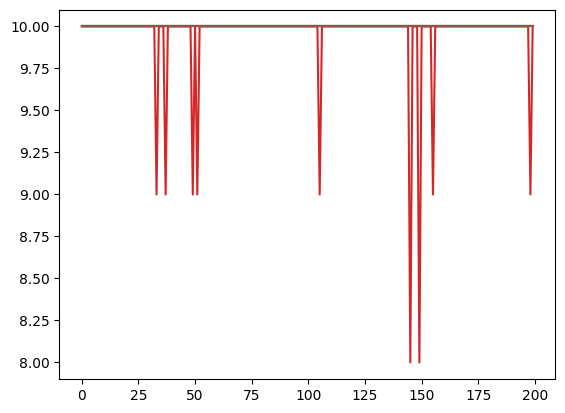

In [16]:
ax_treedepth = plt.plot(idata.sample_stats["tree_depth"].T);
for i in range(len(ax_treedepth)):
    ax_treedepth[i].set_color("C"+str(chainsel[i]))
np.mean(idata.sample_stats["tree_depth"], axis=1)

In [17]:
import arviz as az
rhat = az.rhat(idata)
rhat.max()

/home/test/.local/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset>
Dimensions:                    ()
Data variables: (12/47)
    eta_base                   float64 3.082
    Delta_t_pos_rep            float64 3.365
    Delta_rhos_raw             float64 2.742
    transients_rep_raw         float64 3.14
    delta_base                 float64 2.009
    Delta_t_pos_fatality       float64 2.437
    ...                         ...
    R                          float64 2.377
    D                          float64 2.188
    new_positive               float64 3.547
    new_reported               float64 2.309
    Sero_t                     float64 2.048
    Dead_t                     float64 1.92